In [7]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15

import lightgbm as lgb
import xgboost as xgb
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold
from sklearn import metrics
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML
import json
import altair as alt

import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline



In [8]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [9]:
train = reduce_mem_usage(pd.read_csv('input/train.csv.zip'))
test = reduce_mem_usage(pd.read_csv('input/test.csv.zip'))
mulliken = reduce_mem_usage(pd.read_csv('input/mulliken_charges.csv.zip'))
dipole = reduce_mem_usage(pd.read_csv('input/dipole_moments.csv.zip'))
structure = reduce_mem_usage(pd.read_csv('input/structures.csv.zip'))
potential = reduce_mem_usage(pd.read_csv('input/potential_energy.csv.zip'))
magnetic = reduce_mem_usage(pd.read_csv('input/magnetic_shielding_tensors.csv.zip'))
scaler = reduce_mem_usage(pd.read_csv('input/scalar_coupling_contributions.csv.zip'))
sub = reduce_mem_usage(pd.read_csv('input/sample_submission.csv.zip'))


Mem. usage decreased to 106.62 Mb (50.0% reduction)
Mem. usage decreased to 52.57 Mb (45.0% reduction)
Mem. usage decreased to 16.09 Mb (54.2% reduction)
Mem. usage decreased to  1.13 Mb (56.2% reduction)
Mem. usage decreased to 51.74 Mb (52.1% reduction)
Mem. usage decreased to  0.81 Mb (37.5% reduction)
Mem. usage decreased to 39.49 Mb (69.3% reduction)
Mem. usage decreased to 115.50 Mb (59.4% reduction)
Mem. usage decreased to 11.95 Mb (68.7% reduction)


In [10]:
train.head(10)

id     molecule_name  atom_index_0  atom_index_1  type  \
0   0  dsgdb9nsd_000001             1             0  1JHC   
1   1  dsgdb9nsd_000001             1             2  2JHH   
2   2  dsgdb9nsd_000001             1             3  2JHH   
3   3  dsgdb9nsd_000001             1             4  2JHH   
4   4  dsgdb9nsd_000001             2             0  1JHC   
5   5  dsgdb9nsd_000001             2             3  2JHH   
6   6  dsgdb9nsd_000001             2             4  2JHH   
7   7  dsgdb9nsd_000001             3             0  1JHC   
8   8  dsgdb9nsd_000001             3             4  2JHH   
9   9  dsgdb9nsd_000001             4             0  1JHC   

   scalar_coupling_constant  
0                84.8125000  
1               -11.2578125  
2               -11.2578125  
3               -11.2578125  
4                84.8125000  
5               -11.2578125  
6               -11.2578125  
7                84.8125000  
8               -11.2578125  
9                84.8125000

In [11]:
structure.head(10)

molecule_name  atom_index atom                  x                  y  \
0  dsgdb9nsd_000001           0    C -0.012695312500000  1.085937500000000   
1  dsgdb9nsd_000001           1    H  0.002149581909180 -0.006031036376953   
2  dsgdb9nsd_000001           2    H  1.011718750000000  1.463867187500000   
3  dsgdb9nsd_000001           3    H -0.541015625000000  1.447265625000000   
4  dsgdb9nsd_000001           4    H -0.523925781250000  1.437500000000000   
5  dsgdb9nsd_000002           0    N -0.040435791015625  1.024414062500000   
6  dsgdb9nsd_000002           1    H  0.017257690429688  0.012542724609375   
7  dsgdb9nsd_000002           2    H  0.916015625000000  1.358398437500000   
8  dsgdb9nsd_000002           3    H -0.520507812500000  1.343750000000000   
9  dsgdb9nsd_000003           0    O -0.034362792968750  0.977539062500000   

                   z  
0  0.008003234863281  
1  0.001976013183594  
2  0.000276565551758  
3 -0.876464843750000  
4  0.906250000000000  
5  0.062561035156250  
6 -0.027374267578125  
7 -0.028762817382812  
8 -0.775390625000000  
9  0.007602691650391

In [12]:
def map_atom_info(df, atom_idx):
    df = pd.merge(df, structure, how = 'left',
                  left_on  = ['molecule_name', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_name',  'atom_index'])
    
    df = df.drop('atom_index', axis=1)
    df = df.rename(columns={'atom': f'atom_{atom_idx}',
                            'x': f'x_{atom_idx}',
                            'y': f'y_{atom_idx}',
                            'z': f'z_{atom_idx}'})
    return df

train = map_atom_info(train, 0)
train = map_atom_info(train, 1)

test = map_atom_info(test, 0)
test = map_atom_info(test, 1)

In [13]:
train_p_0 = train[['x_0', 'y_0', 'z_0']].values
train_p_1 = train[['x_1', 'y_1', 'z_1']].values
test_p_0 = test[['x_0', 'y_0', 'z_0']].values
test_p_1 = test[['x_1', 'y_1', 'z_1']].values

In [14]:
train['dist'] = np.linalg.norm(train_p_0 - train_p_1, axis=1)
test['dist'] = np.linalg.norm(test_p_0 - test_p_1, axis=1)


In [15]:
train['dist_0'] = np.linalg.norm(train_p_0 + train_p_1, axis=1)
test['dist_0'] = np.linalg.norm(test_p_0 + test_p_1, axis=1)

train['dist_1'] = np.max(train_p_0 * train_p_1, axis=1)
test['dist_1'] = np.max(test_p_0 * test_p_1, axis=1)

train['dist_2'] = np.min(train_p_0 * train_p_1, axis=1)
test['dist_2'] = np.min(test_p_0 * test_p_1, axis=1)

train['dist_3'] = np.var(train_p_0 * train_p_1, axis=1)
test['dist_3'] = np.var(test_p_0 * test_p_1, axis=1)

In [16]:
train['c_0'] = train.groupby('molecule_name')['id'].transform('count')
test['c_0'] = test.groupby('molecule_name')['id'].transform('count')

train['c_1'] = train.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')
test['c_1'] = test.groupby(['molecule_name', 'atom_index_0'])['id'].transform('count')

train['c_2'] = train.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')
test['c_2'] = test.groupby(['molecule_name', 'atom_index_1'])['id'].transform('count')

train['c_3'] = train['c_2'] / train['c_1']
test['c_3'] = test['c_2'] / test['c_1']

train['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')
test['m_0'] = train.groupby(['molecule_name', 'atom_index_0'])['dist_2'].transform('max')

train['d_0'] = np.max(np.abs(train_p_0 - train_p_1), axis=1)
test['d_0'] = np.max(np.abs(test_p_0 - test_p_1), axis=1)


In [17]:
train['ct_0'] = train.groupby(['molecule_name', 'atom_index_1', 'type'])['id'].transform('count')
test['ct_0'] = test.groupby(['molecule_name', 'atom_index_1', 'type'])['id'].transform('count')

train['ct_1'] = train.groupby(['molecule_name', 'atom_index_0', 'type'])['id'].transform('count')
test['ct_1'] = test.groupby(['molecule_name', 'atom_index_0', 'type'])['id'].transform('count')

train['ct_2'] = train.groupby(['molecule_name', 'type'])['id'].transform('count')
test['ct_2'] = test.groupby(['molecule_name', 'type'])['id'].transform('count')


In [18]:
train = train.merge(potential, on=['molecule_name'], how='left')
test = test.merge(potential, on=['molecule_name'], how='left')

In [19]:
# atom_index_tr = pd.read_csv('input/train.csv.zip', usecols=['atom_index'])
# atom_index_te = pd.read_csv('input/test.csv.zip', usecols=['atom_index'])

In [20]:
y = train['scalar_coupling_constant']

In [21]:
train = pd.read_csv('train_0.csv', index_col=0)
test = pd.read_csv('test_0.csv', index_col=0)

In [22]:
train_1 = pd.read_csv('train_1.csv', index_col=0)
test_1 = pd.read_csv('test_1.csv', index_col=0)

In [23]:
train = pd.concat([train, train_1], axis=1).fillna(0)
test = pd.concat([test, test_1], axis=1).fillna(0)


In [24]:
train_type = pd.read_csv('input/train.csv.zip', usecols=['type', 'scalar_coupling_constant'])
test_type = pd.read_csv('input/test.csv.zip', usecols=['type'])

In [25]:
train['type'] = train_type.type
test['type'] = test_type.type

In [26]:
np.unique(train['type'])

array(['1JHC', '1JHN', '2JHC', '2JHH', '2JHN', '3JHC', '3JHH', '3JHN'],
      dtype=object)

In [27]:
def metric(df, preds):
    df["prediction"] = preds
    maes = []
    for t in df.type.unique():
        y_true = df[df.type==t].scalar_coupling_constant.values
        y_pred = df[df.type==t].prediction.values
        mae = np.log(metrics.mean_absolute_error(y_true, y_pred))
        maes.append(mae)
    return np.mean(maes)
#df for evaluate
eval_df = pd.DataFrame({"type": train["type"]})
eval_df["scalar_coupling_constant"] = y

In [28]:
train.head()

atom_index_0  atom_index_1  type  atom_index_x  atom_0      x_0      y_0  \
0             1             0  1JHC             1       0  0.00215 -0.00603   
1             1             2  2JHH             1       0  0.00215 -0.00603   
2             1             3  2JHH             1       0  0.00215 -0.00603   
3             1             4  2JHH             1       0  0.00215 -0.00603   
4             2             0  1JHC             2       0  1.01200  1.46400   

         z_0  EN_x  rad_x   ...    cos_c0_c1  cos_f0_f1  cos_center0_center1  \
0  0.0019760   2.2   0.43   ...      -1.0000 -0.8164000           0.00000083   
1  0.0019760   2.2   0.43   ...      -0.3335 -0.5005000          -0.33350000   
2  0.0019760   2.2   0.43   ...      -0.3333 -0.0000415          -0.33330000   
3  0.0019760   2.2   0.43   ...      -0.3330 -0.5000000          -0.33300000   
4  0.0002766   2.2   0.43   ...       0.3335  0.0001888           0.00005250   

   cos_c0  cos_c1  cos_f0  cos_f1  cos_center0  cos_center1  atom_n  
0 -1.0000  1.0000 -0.8164  1.0000      -1.0000  -0.00000083       4  
1 -0.8164  0.8174 -1.0000  0.5005      -0.8164   0.81740000       4  
2 -0.8164  0.8170 -0.4998  0.5005      -0.8170   0.81700000       4  
3 -0.8164  0.8164 -0.5000  0.9995      -0.8164   0.81640000       4  
4 -1.0010 -0.3335 -0.8170 -0.3335      -1.0010  -0.00005250       4  

[5 rows x 115 columns]

In [29]:
train.shape

(4658147, 115)

In [30]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'objective': 'regression',
          'max_depth': 10,
          'learning_rate': 0.25,
          "boosting_type": "gbdt",
          "subsample_freq": 1,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1,
          'reg_lambda': 0.3,
          'colsample_bytree': 1.0
         }

In [33]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor


In [ ]:
oof = np.zeros(len(train))
predictions = np.zeros(len(test))
n_split = 5
kf = KFold(n_splits=n_split, random_state=666, shuffle=True)
    
for type_ in np.unique(train['type']):

    
    train_ = train[train['type'] == type_].replace([np.inf, -np.inf], np.nan).fillna(-999)
    test_ = test[test['type'] == type_].replace([np.inf, -np.inf], np.nan).fillna(-999)
    
    train_index = train_.index
    test_index = test_.index
    
    y_ = y[train['type'] == type_]
    
    features = [c for c in train_.columns if c not in ['id', 'molecule_name', 'x_0', 'y_0', 'z_0',
                                                       'x_1', 'y_1', 'z_1', 'atom_index',
                                                       'type', 'scalar_coupling_constant',
                                                       'atom_0', 'atom_1']]

    for i, (train_idx, valid_idx) in enumerate(kf.split(train_)):  
        print(f'Fold {i + 1}')
        x_train = train_[features]
        y_train = y_
       
        clf = ExtraTreesRegressor(n_estimators=666, criterion='mae', max_depth=8,
           min_samples_split=2, min_samples_leaf=5, min_weight_fraction_leaf=0.0, 
           max_features=0.95, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
           bootstrap=False, oob_score=False, n_jobs=-1, 
           random_state=666, verbose=0, warm_start=False)
        clf.fit(x_train.iloc[train_idx], y_train.iloc[train_idx])
        
        oof[train_index[valid_idx]] = clf.predict(x_train.iloc[valid_idx], num_iteration=clf.best_iteration)

        predictions[test_index] += clf.predict(test_[features], num_iteration=clf.best_iteration) / n_split

    
print("CV score: {:<8.5f}".format(metric(eval_df, oof)))

Fold 1


In [ ]:
predictions

In [36]:
test.shape

(2505542, 115)

In [37]:
sub = pd.read_csv('input/sample_submission.csv.zip')

In [38]:
sub.head()

id  scalar_coupling_constant
0  4658147                         0
1  4658148                         0
2  4658149                         0
3  4658150                         0
4  4658151                         0

In [39]:
sub.shape

(2505542, 2)

In [40]:
len(predictions)

2505542

In [41]:
sub['scalar_coupling_constant'] = predictions

sub.to_csv("submission-lgbm-v0.2.2.csv", index=False)

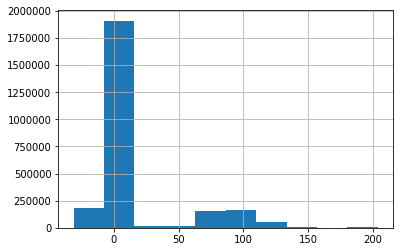

In [42]:
sub['scalar_coupling_constant'].hist()

In [43]:
pd.DataFrame(oof).to_csv('oofs/validation_lgbm_v0.2.2.csv', index=False)
pd.DataFrame(predictions).to_csv('oofs/test_lgbm_v0.2.2.csv', index=False)